In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小

In [2]:
def hand_col(df,col ="发动机转速",n=240):
    
    ####计算col停顿时间
    df["last_notna_time"] = df[df[col].notna()].Time   ##当时不是na的时间
    df_notna_time = df[df[col].notna()].Time
    df_notna_time_diff = (df_notna_time - df_notna_time.shift(1)).dt.total_seconds()
    df["last_notna_time_diff"] = df_notna_time_diff
    df["last_notna_time_diff"] = df["last_notna_time_diff"].fillna(method = "bfill")
    
    df.loc[df["last_notna_time_diff"]> n,col] = df.loc[df["last_notna_time_diff"]> n,col].fillna(0)  #长时间na的填充0
    df[col] = df[col].fillna(method = "ffill")
    return df

In [3]:
def cz(df,idx,col="累计油耗"):
    num = len(idx)
    for i in range(num-1):
        start = idx.iloc[i]
        end = idx.iloc[i+1]
        cz_num = end-start
        start_num = df.loc[start,col]
        end_num = df.loc[end,col]
        fillna = np.linspace(start_num,end_num,cz_num+1)
        df.loc[start:end,col] = fillna
    return df

In [4]:
def hand_col_cz(df,col ="累计油耗"):   ###插值处理
    
    ####计算col停顿间隔
    df["last_notna_idx"] = df[df[col].notna()].idx   ##当时不是na的idx
    df_notna_idx = df[df[col].notna()].idx
    df_notna_idx_diff = (df_notna_idx - df_notna_idx.shift(1))
    df["last_notna_idx_diff"] = df_notna_idx_diff
    df["last_notna_idx_diff"] = df["last_notna_idx_diff"].fillna(method = "bfill")
    
    df.loc[df["last_notna_time_diff"]> n,col] = df.loc[df["last_notna_time_diff"]> n,col].fillna(0)  #长时间na的填充0
    df[col] = df[col].fillna(method = "ffill")
    return df

In [5]:
def hand(df):
    df = df.drop(["GPS纬度","GPS经度","GPS定位时间"],axis=1)#去除无用数据
    df["Time"] = pd.to_datetime(df["time"].str[:-3])#时间转化,直接去掉小数部分
    
    ####停机以发动机数据为准,处理缺失发动机转数
    df = hand_col(df,col ="发动机转速",n=240)
    
    df = hand_col(df,col ="系统压力",n=240)
    
    df = hand_col(df,col ="转向次数",n=240)
    
    df = hand_col(df,col ="泵送排量",n=240)
    
    df = hand_col(df,col ="泵车状态",n=120)
    
    ####油耗单独填充,插值
    df_notna_idx = df[df["累计油耗"].notna()].idx
    df = cz(df,df_notna_idx,col="累计油耗")
    ###
    
    
    ####泵送计时填充
    df["累计时间"] = df["累计时间"].fillna(method = "ffill")
    
    
    
    ####液压油温用插值
    df_notna_idx = df[df["液压油温"].notna()].idx
    df = cz(df,df_notna_idx,col="液压油温")
    return df

In [6]:
def hand_col_new(df,col ="发动机转速",n=240):
    
    ####计算col停顿时间
    df["last_notna_time"] = df[df[col].notna()].second_idx   ##当时不是na的时间
    df_notna_time = df[df[col].notna()].second_idx
    df_notna_time_diff = (df_notna_time - df_notna_time.shift(1))
    df["last_notna_time_diff"] = df_notna_time_diff
    df["last_notna_time_diff"] = df["last_notna_time_diff"].fillna(method = "bfill")
    
    df.loc[df["last_notna_time_diff"]> n,col] = df.loc[df["last_notna_time_diff"]> n,col].fillna(0)  #长时间na的填充0
    df[col] = df[col].fillna(method = "ffill")
#     df = df.drop(["last_notna_time","last_notna_time_diff"],axis=1)
    return df

In [181]:
df = pd.read_csv("data.csv",skiprows=1)
df["Time"] = pd.to_datetime(df["time"].str[:-3])#时间转化,直接去掉小数部分
df["idx"] = np.arange(len(df))
df = hand(df)
df = df.dropna()
df["second"] = df.Time.apply(lambda x: time.mktime(x.timetuple()))
second_start = df.iloc[0].second
df["five_second"] = (df.second - second_start)  // 5
df_mean = df.drop("time",axis=1).groupby("five_second").mean()
df_mean["泵车状态"] = df[["泵车状态","five_second"]].groupby("five_second").max()
start = df.iloc[0].second
end = df.iloc[-1].second
second_index = np.arange(start,end,5)
second_idx = pd.DataFrame({"second_idx":second_index})
new_df = second_idx.join(df_mean)
new_df = new_df.drop(["idx","last_notna_time_diff","second"],axis=1)
new_df["time"] = pd.to_datetime(new_df['second_idx'].values, unit='s',utc=True).tz_convert("Asia/Shanghai").tz_localize(None)

new_df = hand_col_new(new_df,col ="发动机转速",n=240)
new_df = hand_col_new(new_df,col ="系统压力",n=240)
new_df = hand_col_new(new_df,col ="转向次数",n=240)
new_df = hand_col_new(new_df,col ="泵送排量",n=240)
new_df = hand_col_new(new_df,col ="泵车状态",n=240)

new_df["累计油耗"] = new_df["累计油耗"].fillna(method = "bfill")
new_df["累计时间"] = new_df["累计时间"].fillna(method = "bfill")
new_df = new_df.reset_index()
df_notna_idx = new_df[new_df["液压油温"].notna()]["index"]
new_df = cz(new_df,df_notna_idx,col="液压油温")

In [184]:
new_df.dtypes

index                            int64
second_idx                     float64
液压油温                           float64
泵送排量                           float64
累计油耗                           float64
转向次数                           float64
发动机转速                          float64
系统压力                           float64
累计时间                           float64
泵车状态                           float64
time                    datetime64[ns]
last_notna_time                float64
last_notna_time_diff           float64
dtype: object

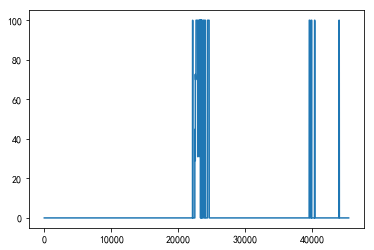

In [185]:
new_df["泵送排量"].plot()

In [206]:
new_df.iloc[22860:23160]

,index,second_idx,液压油温,泵送排量,累计油耗,转向次数,发动机转速,系统压力,累计时间,泵车状态,time,last_notna_time,last_notna_time_diff
22860,22860,1.564363e+09,74.600000,100.0,40.370600,0.000000,1745.666667,34.000000,0.63,0.0,2019-07-29 09:16:59,NaN,25.0
22861,22861,1.564363e+09,74.800000,100.0,40.370600,0.000000,1745.666667,34.000000,0.63,0.0,2019-07-29 09:17:04,NaN,25.0
22862,22862,1.564363e+09,75.000000,100.0,40.370600,0.000000,1714.500000,25.750000,0.63,0.0,2019-07-29 09:17:09,1.564363e+09,25.0
22863,22863,1.564363e+09,75.000000,100.0,40.453416,0.000000,1745.000000,34.000000,0.63,0.0,2019-07-29 09:17:14,1.564363e+09,5.0
22864,22864,1.564363e+09,75.833333,100.0,40.494824,0.000000,1754.333333,15.000000,0.63,0.0,2019-07-29 09:17:19,1.564363e+09,5.0
22865,22865,1.564363e+09,76.000000,100.0,40.552795,0.000000,1745.250000,34.000000,0.63,0.0,2019-07-29 09:17:24,1.564363e+09,5.0
22866,22866,1.564363e+09,76.000000,100.0,40.627329,0.000000,1737.800000,21.000000,0.63,0.0,2019-07-29 09:17:29,1.564363e+09,5.0
22867,22867,1.564363e+09,76.000000,100.0,40.710145,0.000000,1372.000000,13.600000,0.63,0.0,2019-07-29 09:17:34,1.564363e+09,5.0
22868,22868,1.564363e+09,76.000000,100.0,40.792961,0.000000,560.600000,0.000000,0.63,0.0,2019-07-29 09:17:39,1.564363e+09,5.0
22869,22869,1.564363e+09,76.000000,100.0,40.859213,0.000000,559.333333,0.000000,0.63,3.0,2019-07-29 09:17:44,1.564363e+09,5.0


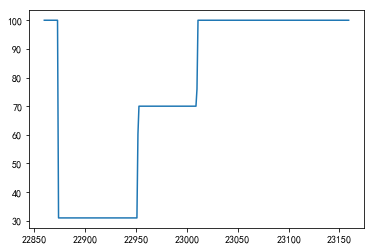

In [205]:
new_df.iloc[22860:23160]["泵送排量"].plot()

In [207]:
start_t = "2019-07-29 09:16:00"
end_t = "2019-07-29 09:41:00"
window = 12*35

In [208]:
start_t = datetime.strptime(start_t, '%Y-%m-%d %H:%M:%S')
end_t = datetime.strptime(end_t, '%Y-%m-%d %H:%M:%S')

In [209]:
start_idx = new_df[new_df.time>=start_t].iloc[0]["index"]
end_idx = new_df[new_df.time<=end_t].iloc[-1]["index"]

In [210]:
####取正样本

In [211]:
win_start = end_idx - window
win_end = start_idx

In [212]:
for tmp_start in range(win_start,win_end,6):
    tmp_cut = new_df.loc[tmp_start:tmp_start+window]
    tmp_cut.to_csv("./True/true"+str(tmp_start)+".csv")

In [213]:
len(range(win_start,win_end,6))

21

In [166]:
####取负样本

In [167]:
np.random.randint(0,(len(new_df)-window))

44637

In [52]:
lenth = len(new_df)

In [214]:
num = 21

In [215]:
while num>0:
    i = np.random.randint(0,(len(new_df)-window))
    if (i > end_idx or i < start_idx-window) and (i<lenth-window):
        cut_df = new_df.loc[i:i+window]
        cut_df.to_csv("./False/false"+str(i)+".csv")
        num -= 1